### Preamble

In [2]:
import os
from collections import defaultdict
from pathlib import Path

import matplotlib as mpl
import numpy as np
import torch

current_dir = Path.cwd()

target_dir = current_dir.parents[1]

os.chdir(target_dir)

print("Working directory changed to:", Path.cwd())

mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "Nimbus Roman No9 L", "STIXGeneral"],
    "mathtext.fontset": "stix",  # math matches Times-ish
    "pdf.fonttype": 42,  # keep text as text in PDF
    "ps.fonttype": 42,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.01,
    "figure.constrained_layout.use": True,  # don't also call tight_layout()
})

Working directory changed to: /home


In [3]:
def pairwise_cosine_similarity(T: torch.Tensor) -> torch.Tensor:

    T_norm = T / T.norm(dim=1, keepdim=True).clamp(min=1e-12)

    S = T_norm @ T_norm.T

    return S

In [10]:
from src.experiment_topology import ExperimentTopology
from src.utils import CustomLogger, Constants
from src.data import SharedDataset
from torch_geometric.loader import DataLoader


train_loader = DataLoader(SharedDataset.CONJUNCTION.train_data[:2])
test_loader = DataLoader(SharedDataset.CONJUNCTION.test_data)

def results(model_type: str, pooling: str, lr: float):
    logger = CustomLogger(level="DEBUG")

    seeds = list(range(101, 401))

    exp = ExperimentTopology(hidden_dim=16,
                             pooling=pooling, lr=lr, weight_decay=0,
                             batch_size=256, model_type=model_type,
                             seeds=seeds, device=Constants.DEVICE,
                             logger=logger)

    agg = defaultdict(list)

    for idx in range(len(seeds)):

        try:
            results = exp._load_results(idx)
        except FileNotFoundError as e:
            continue

        if results['acc'] < .9:  #0.19:
            print("Loss too large")
            continue
        if 'feature_geometry_node' not in results or 'feature_geometry_graph' not in results:
            print("No feature geometry found")
            continue

        agg['model'].append(exp._create_and_fit_model(experiment_idx=idx, train_loader=train_loader, use_cached_models=True, weight=True))
        agg['loss'].append(results['loss'])
        agg['acc'].append(results['acc'])

        agg['features_node'].append(results['feature_geometry_node']['all_features'])

        t = results['feature_geometry_node']['all_features']
        if torch.isnan(t).any():
            raise Exception

        agg['si_node'].append(results['feature_geometry_node']['si'])
        agg['wno_node'].append(results['feature_geometry_node']['WNO_i'])
        agg['auc_node'].append(np.mean(results['feature_geometry_node']['auc']))
        agg['auc_node_all'].append(list(results['feature_geometry_node']['auc']))

        S = pairwise_cosine_similarity(results['feature_geometry_node']['all_features'])
        if 's_node' not in agg:
            agg['s_node'] = S
        else:
            agg['s_node'] += S

        agg['features_graph'].append(results['feature_geometry_graph']['all_features'])

        agg['si_graph'].append(results['feature_geometry_graph']['si'])
        agg['wno_graph'].append(results['feature_geometry_graph']['WNO_i'])
        agg['auc_graph'].append(np.mean(results['feature_geometry_graph']['auc']))
        agg['auc_graph_all'].append(list(results['feature_geometry_graph']['auc']))

        S = pairwise_cosine_similarity(results['feature_geometry_graph']['all_features'])
        if 's_graph' not in agg:
            agg['s_graph'] = S
        else:
            agg['s_graph'] += S

    agg['s_node'] /= len(agg['loss'])
    agg['s_graph'] /= len(agg['loss'])

    agg['features_node'] = torch.stack(agg['features_node'])
    agg['features_graph'] = torch.stack(agg['features_graph'])


    return agg


In [69]:
from src.geometry import structure_of_representation


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data

def visualize_graph(data, one_hot=False):
    # Filter out self-loops before converting to NetworkX
    ei = data.edge_index
    edge_index_no_self_loops = ei[:, ei[0] != ei[1]]
    G = to_networkx(Data(x=data.x, edge_index=edge_index_no_self_loops, y=data.y), to_undirected=True)

    node_color = 'skyblue'
    color_map = {}
    grey_mask = None
    num_feats = 0

    if one_hot and data.x is not None and data.x.ndim == 2 and data.x.shape[1] > 0:
        num_feats = data.x.shape[1]
        _, node_colors = torch.max(data.x, dim=1)
        sum_features = torch.sum(data.x, dim=1)
        grey_mask = (sum_features == 0)
        node_colors[grey_mask] = -1  # sentinel for "no feature"
        node_color = node_colors.tolist()

        # Legend labels
        for k in range(num_feats):
            color_map[k] = f'Feature {k}'

    plt.figure(figsize=(22, 22), dpi=200)

    if one_hot and num_feats > 0:
        # Discrete cmap with an extra "under" color for -1
        cmap = plt.cm.get_cmap('rainbow', num_feats + 1)
        cmap.set_under('grey')
        vmin, vmax = -0.5, num_feats - 0.5

        nx.draw(
            G,
            with_labels=True,
            node_color=node_color,   # ints incl. -1
            node_size=500,
            edge_color='gray',
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
        )

        # Build legend using the SAME mapping
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
        sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

        handles = [
            plt.Line2D([0], [0], marker='o', color='w', label=label,
                       markerfacecolor=sm.to_rgba(k), markersize=10)
            for k, label in color_map.items()
        ]
        if grey_mask is not None and bool(grey_mask.any()):
            handles.insert(0, plt.Line2D([0], [0], marker='o', color='w',
                           label='No feature', markerfacecolor=sm.to_rgba(-1), markersize=10))
        if handles:
            plt.legend(handles=handles, title="Node Features", loc='upper right')

    else:
        # Simple non-one-hot case
        nx.draw(G, with_labels=True, node_color=node_color, node_size=500, edge_color='gray')

    plt.title("Graph Visualization")
    plt.show()



### Stats

In [161]:

results_gcn = results('GCN', 'max', 0.005)
results_gin = results('GIN', 'max', 0.001)
results_gat = results('GAT', 'max', 0.001)


Loss too large
Loss too large
[2025-08-20 17:21:41] [INFO] /home/hxuan/superposition/src/base_model.py:260 in fit() - Using cached model at: /home/hxuan/superposition/models/Exp2_GNN=GCN_pool=max_s=103.pt
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
Loss too large
[2025-08-20 17:21:42] [INFO] /home/hxuan/superposition/src/base_model.py:260 in fit() - Using cached model at: /home/hxu

In [155]:
for res, name in [(results_gcn, 'gcn'), (results_gin, 'gin'), (results_gat, 'gat')]:

    print(name)
    print()
    print(f'n: {len(res['acc'])}')
    print(f'Mean accuracy: {np.nanmean(res['acc']):.2f}')
    print(f'SI node: {np.nanmean(res['si_node']):.2f}')
    print(f'WNO node: {np.nanmean(res['wno_node']):.2f}')
    print(f'SI gr {np.nanmean(res['si_graph']):.2f}')
    print(f'WNO gr: {np.nanmean(res['wno_graph']):.2f}')
    print()

gcn

n: 72
Mean accuracy: 0.94
SI node: 3.59
WNO node: nan
SI gr 1.64
WNO gr: 1.52

gin

n: 187
Mean accuracy: 0.98
SI node: 1.41
WNO node: 1.21
SI gr 1.21
WNO gr: 0.64

gat

n: 141
Mean accuracy: 0.98
SI node: 1.75
WNO node: 1.42
SI gr 1.25
WNO gr: 0.99



/tmp/ipykernel_796010/869529390.py:8: RuntimeWarning: Mean of empty slice
  print(f'WNO node: {np.nanmean(res['wno_node']):.2f}')


### Cosine helpers

In [156]:
from typing import Tuple
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm


def compute_similarity(
    vectors,
    zero_eps: float = 0.0,           # treat norms <= zero_eps as zero
    mode: str = "cos",               # "cos" | "abs" | "cos2"
    warn_limit: int = 10,
):
    """
    vectors: array-like of shape (N, k, D) or (k, D) with k=4 in your current setting.
    Returns:
      S_mean, S_std, V_kept, S_stack, keep_mask
    where S_* are (k,k) and S_stack is (N_kept, k, k).
    """
    try:
        import torch
        if isinstance(vectors, torch.Tensor):
            V = vectors.detach().cpu().numpy()
        else:
            V = np.asarray(vectors)
    except Exception:
        V = np.asarray(vectors)

    V = V.astype(float)

    # accept single instance (k, D)
    if V.ndim == 2:
        V = V[None, ...]
    if V.ndim != 3:
        raise ValueError(f"`vectors` must have shape (N,k,D) or (k,D); got {V.shape}")
    N, k, D = V.shape

    norms = np.linalg.norm(V, axis=2)             # (N,k)
    zero_mask = norms <= float(zero_eps)
    drop_idx = np.where(zero_mask.any(axis=1))[0]

    finite_mask = np.isfinite(V).all(axis=(1,2))
    drop_idx = np.unique(np.concatenate([drop_idx, np.where(~finite_mask)[0]]))

    keep_mask = None
    if drop_idx.size > 0:
        shown = drop_idx[:warn_limit].tolist()
        extra = "" if drop_idx.size <= warn_limit else f" (… +{drop_idx.size - warn_limit} more)"
        print(f"[compute_similarity] Dropping {drop_idx.size}/{N} instances due to zero-norm "
              f"or non-finite vectors. Indices: {shown}{extra}")
        keep_mask = np.ones(N, dtype=bool); keep_mask[drop_idx] = False
        V = V[keep_mask]
        if V.size == 0:
            raise ValueError("All instances were dropped; cannot compute similarity matrices.")

    Vn = V / np.linalg.norm(V, axis=2, keepdims=True)  # (N_kept,k,1)

    S_stack = np.einsum('nid,njd->nij', Vn, Vn)        # cosine (signed)

    if mode == "cos":
        pass
    elif mode == "abs":
        S_stack = np.abs(S_stack)
    elif mode == "cos2":
        S_stack = S_stack**2
    else:
        raise ValueError(f"Unknown mode={mode}. Use 'cos' | 'abs' | 'cos2'.")

    S_mean = S_stack.mean(axis=0)
    S_std  = S_stack.std(axis=0, ddof=1) if S_stack.shape[0] > 1 else np.zeros_like(S_mean)

    return S_mean, S_std, V, S_stack, keep_mask

In [157]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, Normalize
from typing import List, Optional, Tuple

def plot_cosine_heatmaps_grid(
    mats: List[np.ndarray],                      # list of (k,k) mean matrices
    stds: Optional[List[np.ndarray]] = None,     # optional list of (k,k) std matrices
    *,
    mode: str = "cos",                           # "cos" | "abs" | "cos2"
    layout: Optional[Tuple[int,int]] = None,     # (n_rows, n_cols); default: (1, len(mats))
    titles: Optional[List[str]] = None,
    ticklabels: Optional[List[str]] = None,      # default: v1..vk
    figsize: Optional[Tuple[float,float]] = None,
    cmap: Optional[str] = None,                  # default chosen by mode
    vlim: Optional[Tuple[float,float]] = None,   # explicit (vmin, vmax)
    annotate: bool = False,                      # write numbers into cells
    annotate_std: bool = True,                   # show ±std if stds provided
    cell_fontsize: int = 8,                      # font for mean
    cell_std_fontsize: Optional[int] = None,     # font for std (default: ~0.85*mean)
    mean_offset: float = -0.12,                  # vertical offset for mean (in cell units)
    std_offset: float =  0.20,                   # vertical offset for std  (in cell units)
    title_loc: str = "left",
    cbar_kwargs: Optional[dict] = None,          # forwarded to fig.colorbar
):
    """
    Returns (fig, axes, cbar).

    mode:
      - "cos"  : signed cosine in [-1,1], diverging map centered at 0
      - "abs"  : |cos| in [0,1], sequential map
      - "cos2" : cos^2 in [0,1], sequential map
    """
    mats = [np.asarray(M, dtype=float) for M in mats]
    k = mats[0].shape[0]
    assert all(M.shape == (k, k) for M in mats), "All matrices must be (k,k) and the same size."
    n = len(mats)

    if stds is not None:
        stds = [np.asarray(S, dtype=float) for S in stds]
        assert len(stds) == n, "`stds` must match length of `mats`."
        assert all(S.shape == (k, k) for S in stds)

    # Layout
    if layout is None:
        layout = (1, n)
    n_rows, n_cols = layout
    assert n_rows * n_cols == n, "layout must have n_rows * n_cols == len(mats)."

    # Titles and tick labels
    if titles is None:
        titles = [None] * n
    if ticklabels is None:
        ticklabels = [f"$C_{i+3}$" for i in range(k)]

    # Figure size (panel ~3.1x2.6 inches works well in print)
    if figsize is None:
        panel_w, panel_h = 3.1 * 0.7, 2.6 * 0.7
        figsize = (panel_w * n_cols, panel_h * n_rows)

    # Colormap & normalization
    if mode == "cos":
        cmap = "RdBu_r" if cmap is None else cmap
        if vlim is None:
            vmax = max(np.max(np.abs(M)) for M in mats)
            vmax = 1.0 if vmax <= 0 else float(vmax)
            vmin = -vmax
        else:
            vmin, vmax = vlim
        norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)
        cbar_label = "Cosine similarity"
    elif mode in ("abs", "cos2"):
        cmap = "viridis" if cmap is None else cmap
        vmin, vmax = (0.0, 1.0) if vlim is None else vlim
        norm = Normalize(vmin=vmin, vmax=vmax)
        cbar_label = r"$|\cos\theta|$" if mode == "abs" else r"$\cos^2\theta$"
    else:
        raise ValueError("mode must be one of {'cos','abs','cos2'}")

    if cell_std_fontsize is None:
        cell_std_fontsize = max(1, int(round(0.85 * cell_fontsize)))

    # Create axes grid
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=figsize, dpi=300, constrained_layout=True,
        sharex=True, sharey=True
    )
    axes = np.atleast_1d(axes).reshape(n_rows, n_cols)

    ims = []
    for idx, (M, ttl) in enumerate(zip(mats, titles)):
        r = idx // n_cols
        c = idx % n_cols
        ax = axes[r, c]

        im = ax.imshow(M, cmap=cmap, norm=norm, aspect='equal', interpolation='nearest')
        ims.append(im)

        # ticks+labels
        ax.set_xticks(range(k)); ax.set_yticks(range(k))
        ax.set_xticklabels(ticklabels); ax.set_yticklabels(ticklabels)

        # light grid
        ax.set_xticks(np.arange(-.5, k, 1), minor=True)
        ax.set_yticks(np.arange(-.5, k, 1), minor=True)
        ax.grid(which='minor', color='w', linewidth=0.8)
        ax.tick_params(which='minor', bottom=False, left=False)

        if ttl is not None:
            ax.set_title(ttl, loc=title_loc, pad=2)

        # annotation (mean and optional ±std on separate lines with different fonts)
        if annotate:
            S_here = stds[idx] if (stds is not None and annotate_std) else None
            for i in range(k):
                for j in range(k):
                    ax.text(
                        j, i + mean_offset, f"{M[i,j]:.2f}",
                        ha='center', va='center', fontsize=cell_fontsize
                    )
                    if S_here is not None:
                        ax.text(
                            j, i + std_offset, f"±{S_here[i,j]:.2f}",
                            ha='center', va='center', fontsize=cell_std_fontsize
                        )

    # Shared colorbar
    if cbar_kwargs is None:
        cbar_kwargs = dict(location='right', fraction=0.046, pad=0.04)
    cbar = fig.colorbar(ims[0], ax=axes.ravel().tolist(), **cbar_kwargs)
    cbar.set_label(cbar_label)

    return fig, axes, cbar

## Plots

In [211]:
from src.features import IsInsideMotifFamily
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


concept_family = IsInsideMotifFamily()
model = results_gcn['model'][10]

H = []

def _node_embeddings_from_batch(
    data,
    layer_idx: int = -1,
    pre_relu: bool = False,
) -> torch.Tensor:
    x, edge_index = data.x, data.edge_index
    for i, conv in enumerate(model.convs):
        x = conv(x, edge_index)
        is_last = (i == len(model.convs) - 1)
        if (i == layer_idx) and pre_relu and not is_last:
            return x
        if not is_last:
            x = torch.nn.functional.relu(x)
        if i == layer_idx:
            return x
    return x


node_embeddings = []
graph_embeddings = []
concept_labels = []

with torch.inference_mode():
    for data in test_loader:
        data = data.to(model.device, non_blocking=True)

        T_batch = concept_family.detect(data)  # (N_b, C_f)

        H_batch = _node_embeddings_from_batch(
            data, layer_idx=2, pre_relu=False
        )

        _, graph_embeddings_batch = model.forward(data.x, data.edge_index, data.batch, return_repr=True)

        if H_batch.size(0) != T_batch.size(0):
            raise RuntimeError(
                f"Node count mismatch: H[{H_batch.size(0)}] vs labels[{T_batch.size(0)}]"
            )
        node_embeddings.append(H_batch.detach().cpu())
        concept_labels.append(T_batch.detach().cpu())
        graph_embeddings.append(graph_embeddings_batch.detach().cpu())


In [212]:
X = torch.cat(node_embeddings, dim=0).numpy()
X[np.abs(X) < 1e-6] = 0
X

array([[-6.9444328e+01,  3.3354759e-01,  1.0209159e+01, ...,
        -1.3149562e+00, -6.6032469e-02, -1.1748885e-01],
       [-4.4645699e+01, -8.1006908e-01,  7.0930195e+00, ...,
        -8.8675565e-01, -4.5225959e-02, -6.8448655e-02],
       [-4.4645699e+01, -8.1006908e-01,  7.0930195e+00, ...,
        -8.8675565e-01, -4.5225959e-02, -6.8448655e-02],
       ...,
       [-4.6476151e+01, -9.8975372e-01,  6.4218044e+00, ...,
        -9.0146130e-01, -4.4994395e-02, -7.4641965e-02],
       [-4.9037483e+01, -6.5111518e-01,  7.3592424e+00, ...,
        -9.2946297e-01, -4.6419580e-02, -6.9228902e-02],
       [-5.4712898e+01, -3.8267040e-01,  7.8948202e+00, ...,
        -9.8563093e-01, -4.8166778e-02, -6.8704054e-02]], dtype=float32)

In [204]:


X = torch.cat(node_embeddings, dim=0).numpy()
X[np.abs(X) < 1e-6] = 0
T = torch.cat(concept_labels, dim=0).numpy()

N, D = X.shape
C_f = T.shape[1]

scaler = StandardScaler(with_mean=True, with_std=True)
Xs = scaler.fit_transform(X)
std = scaler.scale_.astype(np.float64)
std[std == 0.0] = 1.0
mean = scaler.mean_.astype(np.float64)

W_orig = np.zeros((C_f, D), dtype=np.float64)
b_orig = np.zeros((C_f,), dtype=np.float64)
active_mask: List[bool] = [False] * C_f
auroc_by_concept: List[float] = [float("nan") for _ in range(C_f)]

# One-vs-rest logistic for each concept
for c in range(C_f):
    y = T[:, c].astype(np.int32)
    pos = int(y.sum())
    neg = int(len(y) - pos)
    # Prevalence gate
    if pos < 50 or neg < 50:
        continue

    # Fit
    clf = LogisticRegression(
        penalty="l2",
        C= 1.0,
        solver="liblinear",
        class_weight="balanced",
        max_iter=500,
        random_state=0,
    )
    clf.fit(Xs, y)

    # Compute AUROC from calibrated scores (logit)
    # z = w_std^T * Xs + b_std
    scores = clf.decision_function(Xs)
    try:
        auc = roc_auc_score(y, scores)
    except ValueError:
        auc = float("nan")
    auroc_by_concept[c] = float(auc)

    if not np.isfinite(auc) or auc < 0.6:
        continue  # not active

    # Map weights back to ORIGINAL embedding space:
    # logit = w_std^T * ((x - mean)/std) + b_std
    #       = (w_std/std)^T x + (b_std - (w_std/std)^T mean)
    w_std = clf.coef_.ravel().astype(np.float64)
    b_std = float(clf.intercept_.ravel()[0])
    w_o = w_std / std
    b_o = b_std - np.dot(w_o, mean)
    W_orig[c] = w_o
    b_orig[c] = b_o
    active_mask[c] = True

W_t = torch.from_numpy(W_orig).float().to(model.device)  # [C_f, D]
b_t = torch.from_numpy(b_orig).float().to(model.device)  # [C_f]

In [207]:
torch.cat(graph_embeddings, dim=0).numpy()

array([[0.       , 0.       , 0.       , ..., 0.       , 2.5599256,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 2.557617 ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 2.471908 ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 2.5572355,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 2.5598674,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 2.5596018,
        0.       ]], dtype=float32)

In [186]:
X

array([[-3.49350609e-02, -1.98339466e-02, -5.31910025e-02, ...,
        -1.21797798e-02,  1.76897836e+00, -3.87216453e-10],
       [-2.30995100e-02, -1.31068164e-02, -3.51849757e-02, ...,
        -8.04002024e-03,  6.02163315e-01, -2.54265609e-10],
       [-2.30995100e-02, -1.31068164e-02, -3.51849757e-02, ...,
        -8.04002024e-03,  6.02163315e-01, -2.54265609e-10],
       ...,
       [-2.36179307e-02, -1.33905197e-02, -3.59971896e-02, ...,
        -8.20066687e-03, -1.08015776e+00, -2.57356442e-10],
       [-2.36514546e-02, -1.34096015e-02, -3.60480659e-02, ...,
        -8.21250584e-03, -6.98134422e-01, -2.57780963e-10],
       [-2.43594944e-02, -1.38059631e-02, -3.71381193e-02, ...,
        -8.44882429e-03, -7.73589849e-01, -2.64306327e-10]], dtype=float32)

In [187]:
Xs

array([[-2.6129754 , -2.6208389 , -2.606722  , ..., -2.6371164 ,
         0.6719221 , -2.712702  ],
       [-0.38486972, -0.37910166, -0.3893967 , ..., -0.36707303,
        -0.5851737 , -0.3092896 ],
       [-0.38486972, -0.37910166, -0.3893967 , ..., -0.36707303,
        -0.5851737 , -0.3092896 ],
       ...,
       [-0.48246518, -0.4736424 , -0.4894156 , ..., -0.45516387,
        -2.3976622 , -0.36516398],
       [-0.48877624, -0.4800012 , -0.49568066, ..., -0.46165577,
        -1.9860802 , -0.37283826],
       [-0.6220685 , -0.6120841 , -0.6299137 , ..., -0.5912413 ,
        -2.067374  , -0.4908002 ]], dtype=float32)

/tmp/ipykernel_796010/1216345640.py:94: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


(<Figure size 800x700 with 1 Axes>,
 <Axes: title={'center': 'PCA (2D) by class'}, xlabel='PC1 (57.1% var)', ylabel='PC2 (23.4% var)'>,
 {'explained_ratio': array([0.57145673, 0.23417239], dtype=float32),
  'counts': {'class 0': 16605,
   'class 1': 12072,
   'class 2': 15895,
   'class 3': 19092}})

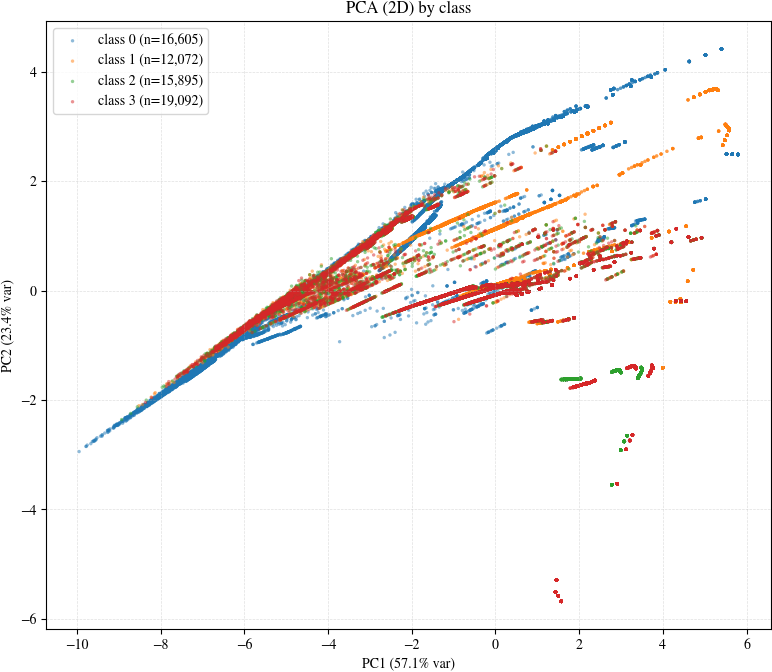

In [52]:
def plot_pca_with_onehot_labels(
    X,
    L,
    *,
    standardize=True,
    sample=None,
    random_state=0,
    figsize=(8, 7),
    alpha=0.5,
    s=6,
    title="PCA (2D) by class"
):

    import numpy as np
    import matplotlib.pyplot as plt

    X = np.asarray(X)
    L = np.asarray(L)
    if X.ndim != 2:
        raise ValueError("X must be 2D (N×D).")
    if L.ndim != 2 or L.shape[1] != 4 or L.shape[0] != X.shape[0]:
        raise ValueError("L must be shape (N, 4) and match X's rows.")

    N = X.shape[0]

    # Determine labels: 0..3 are classes; 4 is 'no class' (all zeros)
    row_sums = L.sum(axis=1)
    has_class = row_sums > 0
    y = np.full(N, 4, dtype=int)  # default 'no class'
    if has_class.any():
        y[has_class] = np.argmax(L[has_class], axis=1)

    # Optional sampling to lighten the plot for very large N
    rng = np.random.default_rng(random_state)
    if sample is None:
        idx = np.arange(N)
    elif isinstance(sample, (int, np.integer)) and sample >= 1:
        k = min(int(sample), N)
        idx = rng.choice(N, size=k, replace=False)
    elif isinstance(sample, (float, np.floating)) and 0.0 < float(sample) < 1.0:
        k = max(1, int(round(N * float(sample))))
        idx = rng.choice(N, size=k, replace=False)
    else:
        raise ValueError("sample must be None, int >= 1, or 0< float <1.")

    Xp = X[idx]
    yp = y[idx]

    # Standardize (z-score) then PCA via SVD
    if standardize:
        mu = Xp.mean(axis=0, keepdims=True)
        sd = Xp.std(axis=0, ddof=0, keepdims=True)
        sd = np.where(sd == 0, 1.0, sd)  # avoid divide-by-zero
        Z = (Xp - mu) / sd
    else:
        Z = Xp - Xp.mean(axis=0, keepdims=True)

    # SVD: scores = U * S (columns correspond to PCs)
    U, S, Vt = np.linalg.svd(Z, full_matrices=False)
    scores = U[:, :2] * S[:2]  # 2D PCA coordinates

    # Explained variance ratio
    # For SVD on centered Z: eigenvalues = S^2 / (n-1)
    eigvals = (S ** 2) / (Z.shape[0] - 1)
    explained_ratio = eigvals[:2] / eigvals.sum()

    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    names = ["class 0", "class 1", "class 2", "class 3", "no class"]
    # Distinct, readable colors (last is gray for 'no class')
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#7f7f7f"]

    counts = {}
    for k, (name, color) in enumerate(zip(names, colors)):
        m = (yp == k)
        if m.any():
            ax.scatter(
                scores[m, 0],
                scores[m, 1],
                s=s,
                alpha=alpha,
                label=f"{name} (n={m.sum():,})",
                c=color,
                edgecolors="none",
                rasterized=True,
            )
            counts[name] = int(m.sum())

    ax.set_xlabel(f"PC1 ({explained_ratio[0]*100:.1f}% var)")
    ax.set_ylabel(f"PC2 ({explained_ratio[1]*100:.1f}% var)")
    ax.set_title(title)
    ax.legend(loc="best", frameon=True)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.4)
    fig.tight_layout()

    info = {"explained_ratio": explained_ratio, "counts": counts}
    return fig, ax, info


plot_pca_with_onehot_labels(X[T.sum(axis=1) > 0],T[T.sum(axis=1) > 0])

In [153]:
X

array([[-1.5532321e+02,  5.1653622e+01, -6.0377584e-12, ...,
        -2.3967509e+00, -2.1088394e+01,  7.4450378e+01],
       [-8.6334023e+01,  2.4044827e+01, -3.1853647e-12, ...,
        -1.1823096e+00, -1.4767453e+01,  2.5540264e+01],
       [-8.6334023e+01,  2.4044827e+01, -3.1853647e-12, ...,
        -1.1823096e+00, -1.4767453e+01,  2.5540264e+01],
       ...,
       [-1.0412241e+02,  2.8161966e+01, -3.8559824e-12, ...,
        -1.4327272e+00, -1.8532415e+01,  3.0605499e+01],
       [-1.0316076e+02,  2.7797033e+01, -3.8488769e-12, ...,
        -1.4191320e+00, -1.8440378e+01,  2.9962036e+01],
       [-1.1266191e+02,  2.9827911e+01, -4.2097502e-12, ...,
        -1.5504420e+00, -2.0545416e+01,  3.2187073e+01]], dtype=float32)

(array([2.000e+00, 5.000e+00, 3.000e+00, 1.800e+01, 2.400e+01, 5.600e+01,
        8.500e+01, 1.140e+02, 1.710e+02, 2.260e+02, 2.560e+02, 3.010e+02,
        3.760e+02, 3.120e+02, 5.100e+02, 4.280e+02, 5.100e+02, 4.090e+02,
        4.100e+02, 3.670e+02, 2.670e+02, 3.650e+02, 2.590e+02, 2.730e+02,
        2.390e+02, 1.940e+02, 1.260e+02, 1.120e+02, 1.130e+02, 1.340e+02,
        2.180e+02, 3.900e+02, 5.620e+02, 1.172e+03, 1.185e+03, 1.716e+03,
        1.768e+03, 1.662e+03, 9.020e+02, 1.722e+03, 6.960e+02, 4.610e+02,
        8.350e+02, 2.510e+02, 2.240e+02, 3.250e+02, 1.610e+02, 2.100e+02,
        1.650e+02, 1.600e+02, 1.030e+02, 1.530e+02, 5.500e+01, 5.180e+02,
        7.012e+03]),
 array([-5.51482124e-12, -5.41455292e-12, -5.31428417e-12, -5.21401585e-12,
        -5.11374753e-12, -5.01347922e-12, -4.91321046e-12, -4.81294215e-12,
        -4.71267383e-12, -4.61240508e-12, -4.51213676e-12, -4.41186844e-12,
        -4.31159969e-12, -4.21133137e-12, -4.11106305e-12, -4.01079430e-12,
        -

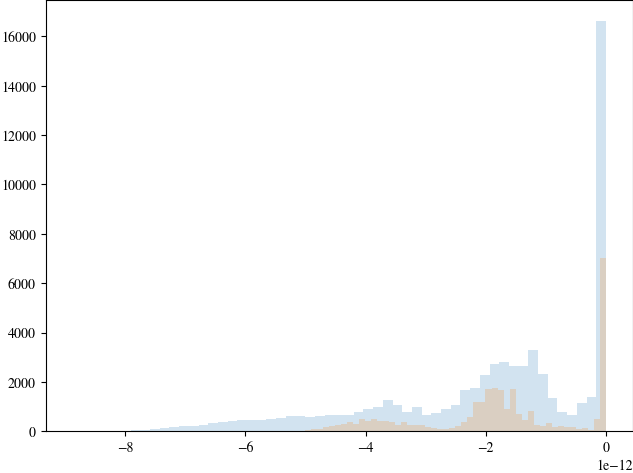

In [180]:
plt.hist(X[T.sum(axis=1) == 1, 2], bins=55, alpha=0.2)
plt.hist(X[T.sum(axis=1) == 0, 2], bins=55, alpha=0.2)


In [141]:
results_gin['auc_node_all'][0]

[0.9270281164079195,
 0.8772653842204409,
 0.7753306889138403,
 0.8856930118491434]

In [165]:
g1 = [g for g in SharedDataset.CONJUNCTION.test_data if g.y[0] == 1 and g.y[1] == 0 and g.x.shape[0] < 55][0]
g2 = [g for g in SharedDataset.CONJUNCTION.test_data if g.y[0] == 0][44]

/home/hxuan/miniconda3/envs/torchgpu/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


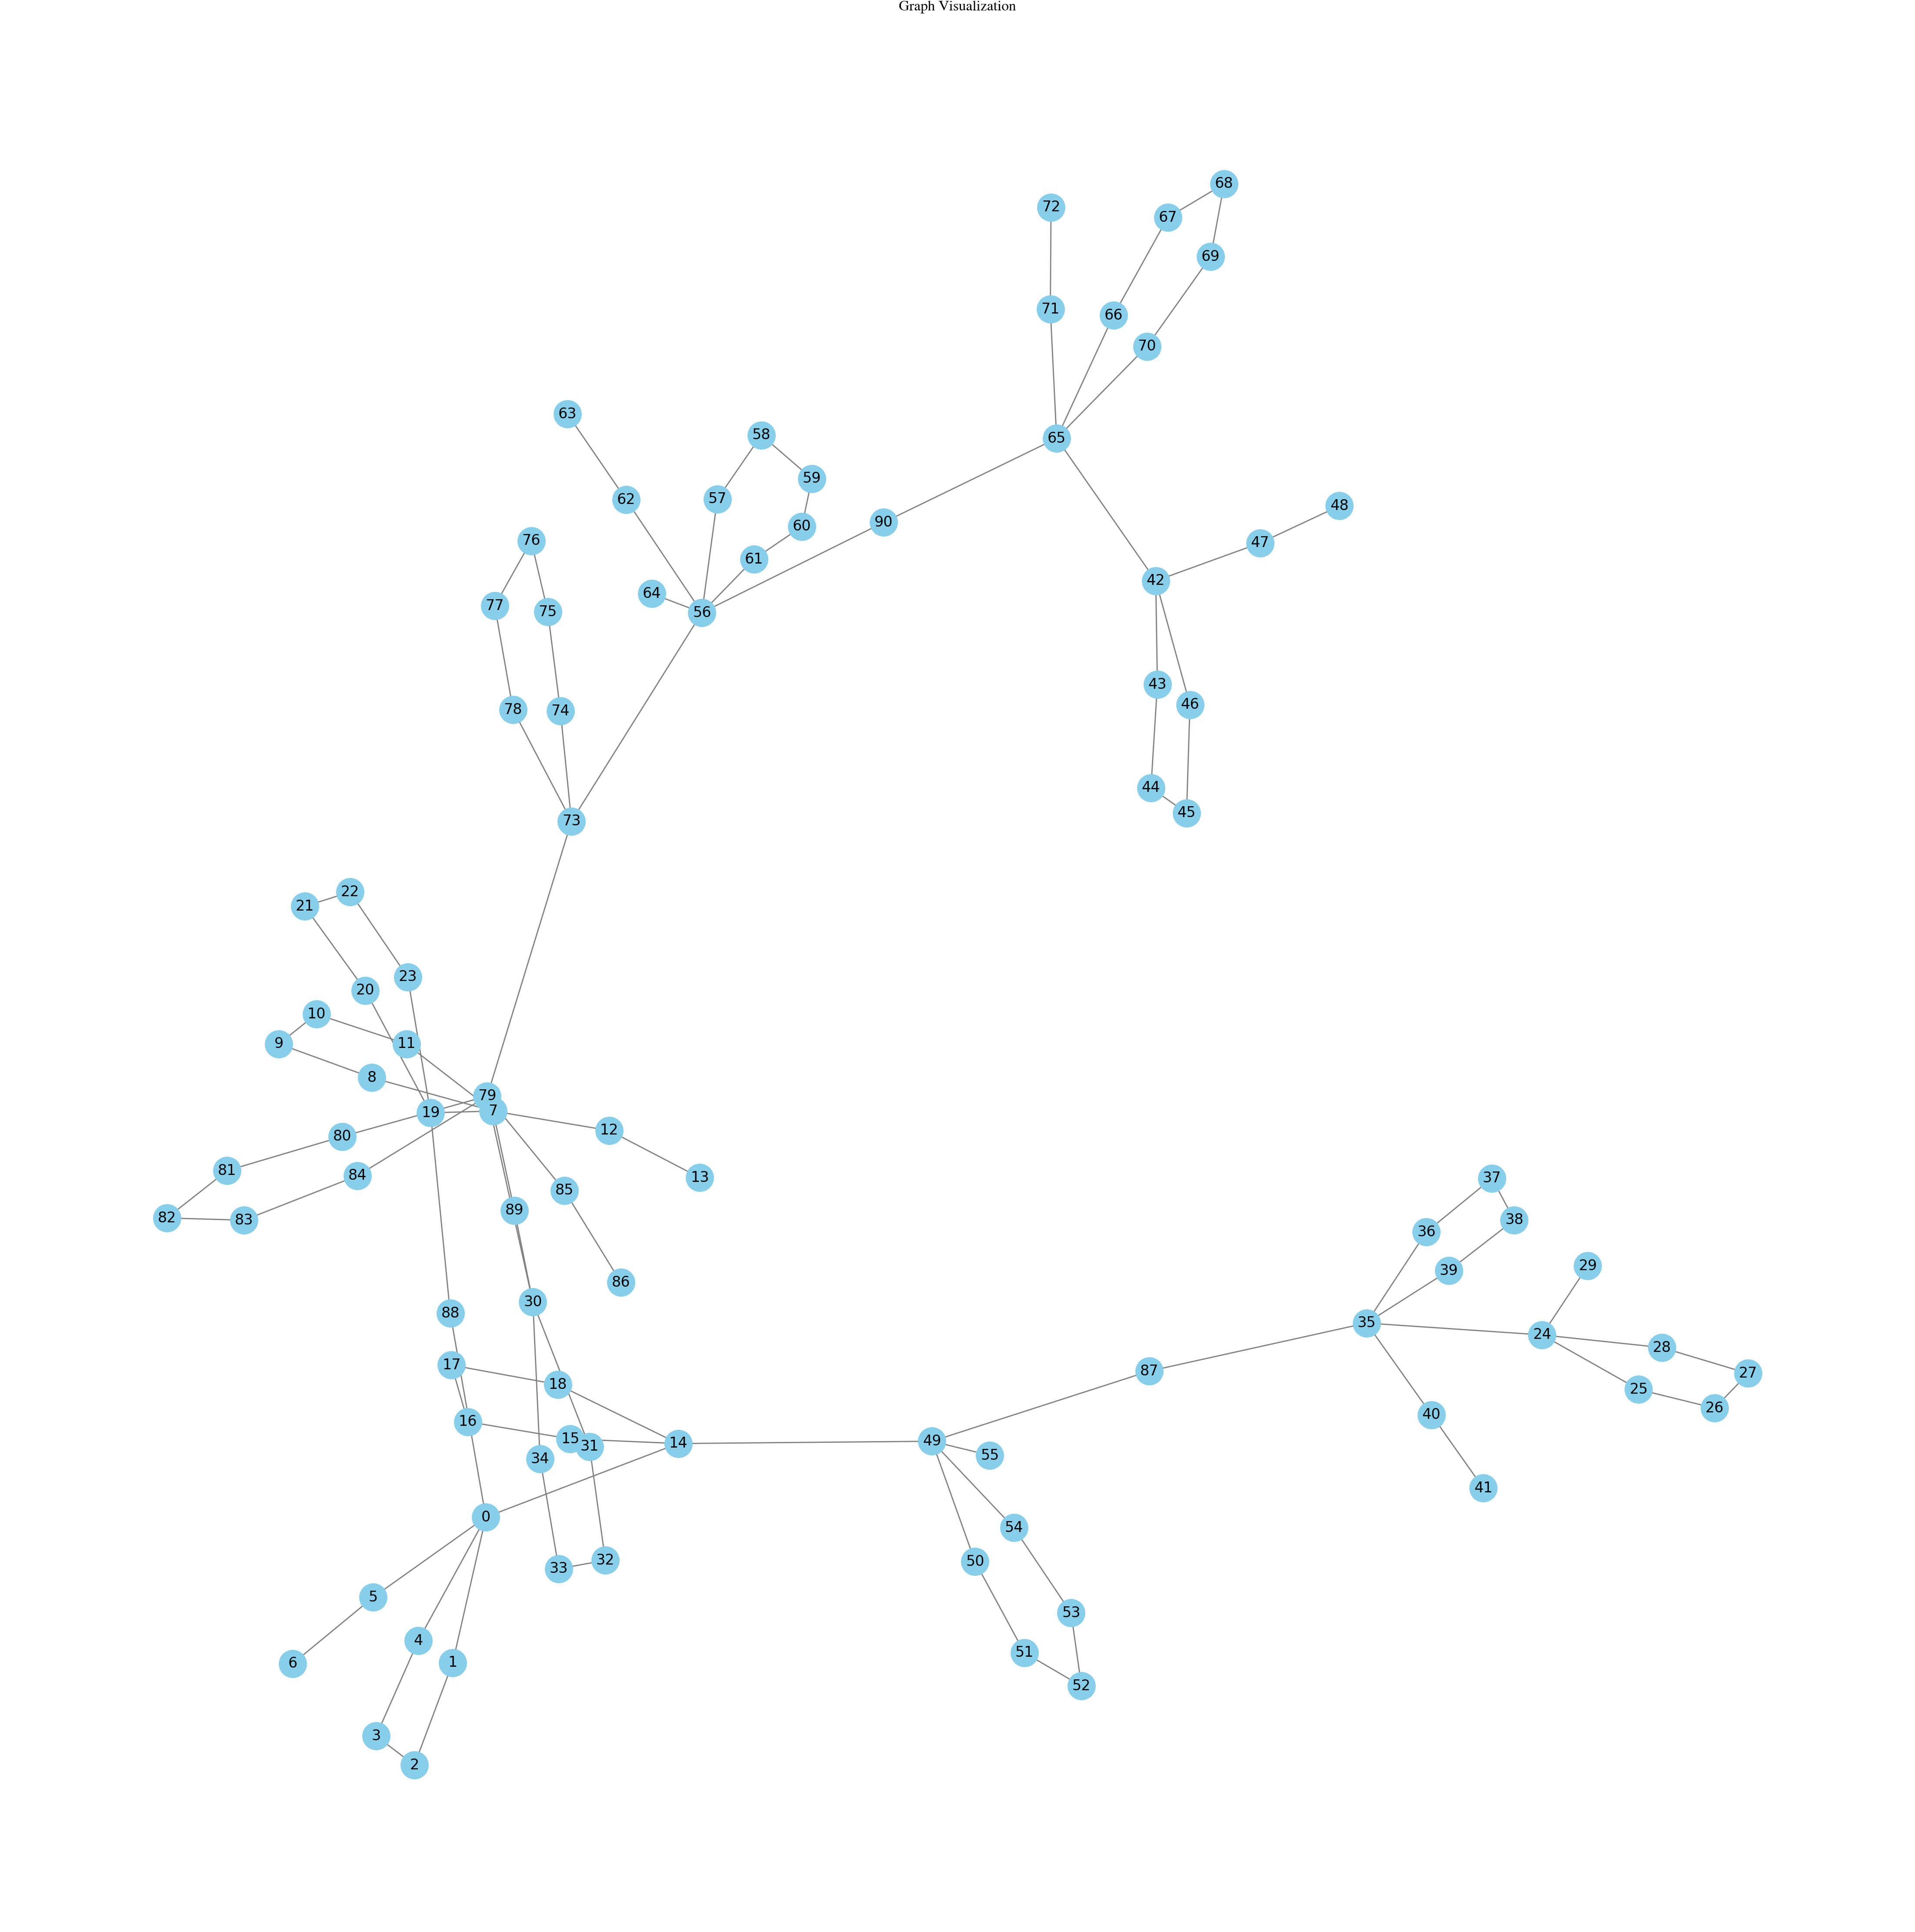

In [166]:

visualize_graph(g2)

In [167]:
_node_embeddings_from_batch(g2.to(model.device))

tensor([[-1.3617e+02,  3.7914e+01, -4.4032e-12,  ..., -1.8655e+00,
         -1.0707e+00,  2.6308e+01],
        [-6.8735e+00,  1.8524e+01, -1.4398e-12,  ..., -8.8867e-01,
          6.4826e+00,  3.8325e+01],
        [ 3.9331e+01,  2.3437e+01, -9.4800e-17,  ..., -3.8346e-01,
          3.0215e+01,  1.6386e+01],
        ...,
        [-1.0246e+02,  2.7438e+01, -3.8135e-12,  ..., -1.4065e+00,
         -1.8387e+01,  2.9397e+01],
        [-1.0208e+02,  2.7358e+01, -3.7990e-12,  ..., -1.4012e+00,
         -1.8301e+01,  2.9310e+01],
        [-1.1935e+02,  3.1267e+01, -4.4482e-12,  ..., -1.6407e+00,
         -2.2008e+01,  3.3504e+01]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [188]:
model.forward(g1.x.to(model.device), g1.edge_index.to(model.device), None, True)

(tensor([[ 3.5760, -5.3484]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0379, 0.1221, 0.9067, 0.0000, 2.6591,
          5.7471, 0.0000, 0.9732, 0.0000, 0.0000, 2.3229, 0.0000]],
        device='cuda:0', grad_fn=<ReluBackward0>))

In [189]:
model.forward(g2.x.to(model.device), g2.edge_index.to(model.device), None, True)

(tensor([[-5.3520, -3.5621]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5139, 0.3653, 0.0000, 2.2537,
          5.6352, 0.0000, 0.5112, 0.0000, 0.0000, 2.4184, 0.0000]],
        device='cuda:0', grad_fn=<ReluBackward0>))

In [59]:
graph.y

tensor([1., 1.])

In [115]:
results_gin['si_node'][0]

3.987143013653834

In [171]:
results_gcn['features_node'][0]

tensor([[ 7.6268e+00, -1.1589e+01, -5.9657e+00, -6.6441e+03, -4.5553e+00,
         -1.5451e+03, -1.0917e+07, -1.0102e+01, -4.5452e+01, -6.3855e+07,
         -5.4179e+04,  3.8064e+10, -6.7346e+00,  5.6805e+01, -3.6246e+00,
          2.4319e+01],
        [-2.2562e+01,  1.4721e+02, -2.0000e+02, -2.1311e+04,  2.5239e+01,
         -4.9173e+03, -3.4062e+07, -2.2672e+00, -2.0971e+02, -2.0241e+08,
         -1.7615e+05,  8.4943e+10, -4.3234e+01,  3.2909e+02, -6.2363e+01,
          2.0315e+02],
        [-1.3233e+01,  7.5897e+01, -6.6339e+01, -5.0727e+03,  7.0509e+00,
         -1.1643e+03, -7.9667e+06,  3.3195e+00, -5.8495e+01, -4.7819e+07,
         -4.2261e+04,  1.4773e+10, -6.9492e+00,  1.0632e+02, -2.7090e+01,
          7.0305e+01],
        [-1.1922e+01,  5.4137e+01,  5.3791e+00,  4.4800e+03, -3.6068e+00,
          1.0449e+03,  7.4299e+06,  8.5696e+00,  2.8261e+01,  4.3231e+07,
          3.6369e+04, -2.8301e+10,  1.6805e+01, -1.0098e+01, -1.2293e+01,
          2.6820e+00]], device='cuda:0')

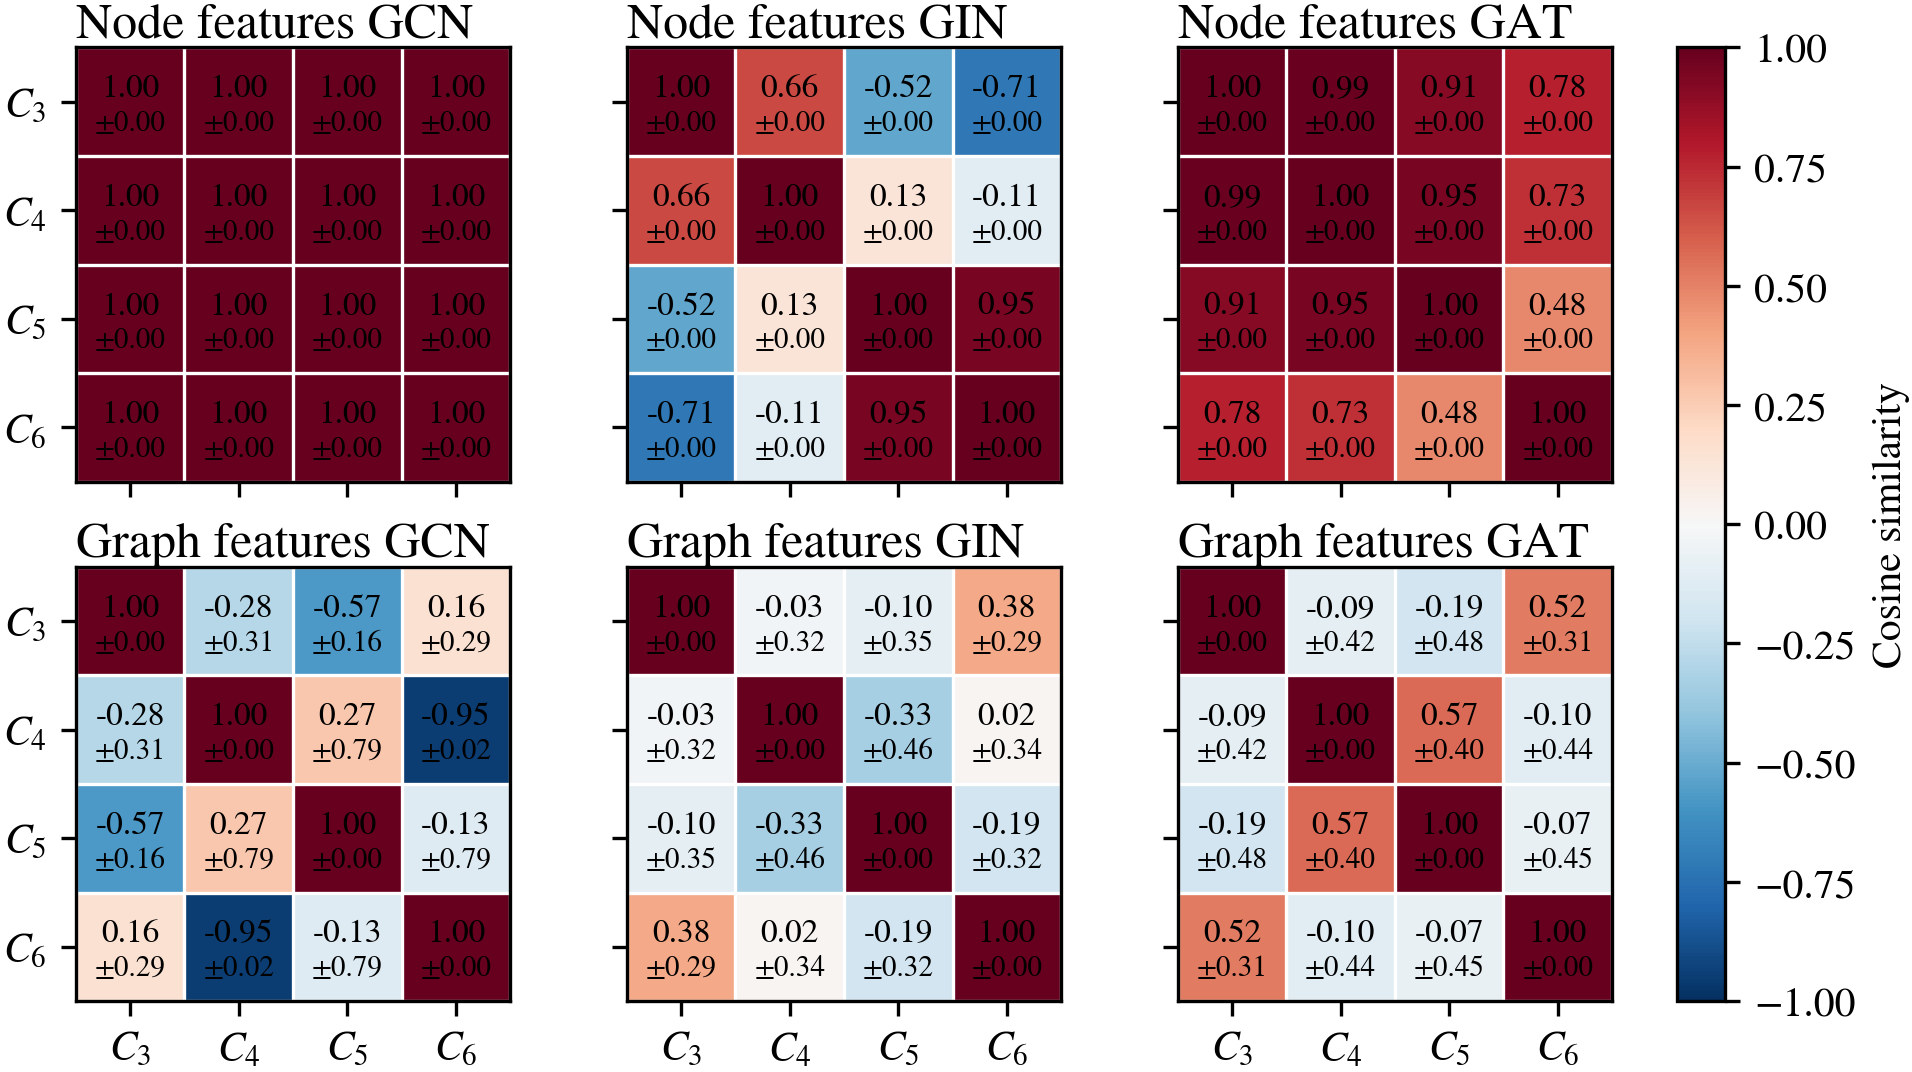

In [158]:
cos_gcn_node,  cos_gcn_node_std, _, _, _  = compute_similarity(vectors=results_gcn['features_node'][0], mode='cos')
cos_gcn_graph, cos_gcn_graph_std, _, _, _ = compute_similarity(vectors=results_gcn['features_graph'], mode='cos')
cos_gin_node,  cos_gin_node_std, _, _, _  = compute_similarity(vectors=results_gin['features_node'][0] , mode='cos')
cos_gin_graph, cos_gin_graph_std, _, _, _ = compute_similarity(vectors=results_gin['features_graph'], mode='cos')
cos_gat_node,  cos_gat_node_std, _, _, _  = compute_similarity(vectors=results_gat['features_node'][0], mode='cos')
cos_gat_graph, cos_gat_graph_std, _, _, _ = compute_similarity(vectors=results_gat['features_graph'], mode='cos')

fig, axes, cbar = plot_cosine_heatmaps_grid(
    mats=[cos_gcn_node, cos_gin_node, cos_gat_node, cos_gcn_graph, cos_gin_graph , cos_gat_graph],
    stds=[cos_gcn_node_std, cos_gin_node_std, cos_gat_node_std, cos_gcn_graph_std, cos_gin_graph_std, cos_gat_graph_std],
    titles=["Node features GCN", "Node features GIN", "Node features GAT", "Graph features GCN", "Graph features GIN", "Graph features GAT"],
    layout=(2,3),
    annotate=True,
    annotate_std=True
)

# plt.savefig("figures/cosine_side_by_side_mean.pdf", bbox_inches="tight", pad_inches=0.01)



In [291]:
matrices_node[5]

tensor([[ 6.9991e+00, -5.4048e+00,  1.7772e+00, -3.4753e-01,  5.9557e-01,
          1.6414e+01, -2.1827e-02,  8.6667e+00, -5.1832e+00, -2.3790e+01,
          3.9433e+01, -3.1690e+00, -8.3469e-01, -6.2017e+00, -2.0386e+01,
         -5.4823e+00],
        [ 1.3838e+01, -6.1711e+00,  1.9580e+00,  2.6652e+00,  8.1036e-01,
          2.4062e-01,  4.0209e-01,  1.1434e+01,  3.7001e+00, -2.4302e+00,
          1.2896e+01, -8.3152e+00,  8.8360e-01, -6.1391e+00, -2.3077e+01,
         -5.7162e+00],
        [ 2.9337e+00, -2.1599e+00,  3.3823e-02,  6.5482e-01, -2.8588e-01,
         -8.3489e+00,  1.2095e-01, -2.7716e+00, -1.2208e+00,  1.1182e+01,
         -9.7894e+00, -1.6175e+00,  2.6788e+00,  7.2722e-01,  6.5473e+00,
          6.2283e-01],
        [-3.5684e+00, -1.3351e+00,  1.6393e-01,  7.4989e-01,  4.4846e-01,
          2.1426e+00, -9.0865e-02,  9.7152e+00, -7.7052e-01, -1.3783e+00,
          2.0637e+00, -3.1397e+00,  2.4827e-01, -1.4869e+00, -7.8043e+00,
         -2.5212e+00]])

In [240]:
results_gin['si_node'][5]

1.4842638386778058

### WNO and SI

In [42]:
from typing import Dict, Iterable, Literal, Optional, Union
import numpy as np
import matplotlib.pyplot as plt

ArrayLike = Union[Iterable[float], np.ndarray]

def plot_overlaid_histograms(
    datasets: Dict[str, ArrayLike],       # {"GIN": arr, "GAT": arr, ...}
    xlabel: str = "SI",
    bins: Union[int, str, np.ndarray] = "fd",  # "fd"=Freedman–Diaconis; or int; or explicit edges
    normalize: Literal["density", "probability", "count"] = "density",
    alpha_fill: float = 0.25,             # translucency for filled bars (0 disables fill)
    step_only: bool = False,              # True = outlines only (no fill)
    linewidth: float = 1.6,
):
    if not datasets:
        raise ValueError("Provide at least one dataset.")

    # ----- shared bins across all models -----
    combined = np.concatenate([np.asarray(v, dtype=float) for v in datasets.values()])
    combined = combined[np.isfinite(combined)]
    if isinstance(bins, (int, np.integer)) or isinstance(bins, np.ndarray):
        edges = np.histogram_bin_edges(combined, bins=bins)
    else:  # string rule like "fd", "auto", "doane", ...
        edges = np.histogram_bin_edges(combined, bins=bins)

    # ----- normalization choice & y-label -----
    y_label = {"density": "Density", "probability": "Proportion of samples", "count": "Count"}[normalize]
    use_density = (normalize == "density")

    plt.figure(figsize=(3.25, 2.1), dpi=300, constrained_layout=True)
    ax = plt.gca()

    # consistent styling
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    for label, data in datasets.items():
        x = np.asarray(data, dtype=float)
        x = x[np.isfinite(x)]
        if x.size == 0:
            continue

        if normalize == "probability":
            weights = np.ones_like(x) / x.size      # bars sum to 1 (not area)
            density = False
        elif normalize == "density":
            weights = None
            density = True                           # area = 1 (depends on bin width)
        else:  # "count"
            weights = None
            density = False

        # Step outline avoids occlusion; optional translucent fill for readability
        ax.hist(
            x, bins=edges, density=density, weights=weights,
            histtype="step", linewidth=linewidth, label=f"{label}"
        )
        if not step_only and alpha_fill > 0:
            ax.hist(
                x, bins=edges, density=density, weights=weights,
                histtype="stepfilled", alpha=alpha_fill
            )

    ax.set_xlabel(xlabel)
    ax.set_ylabel(y_label)

    if len(datasets) > 1:
        ax.legend(frameon=False, fontsize=9)
    ax.margins(x=0.02)
    plt.tight_layout()

/tmp/ipykernel_756701/1570804712.py:71: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


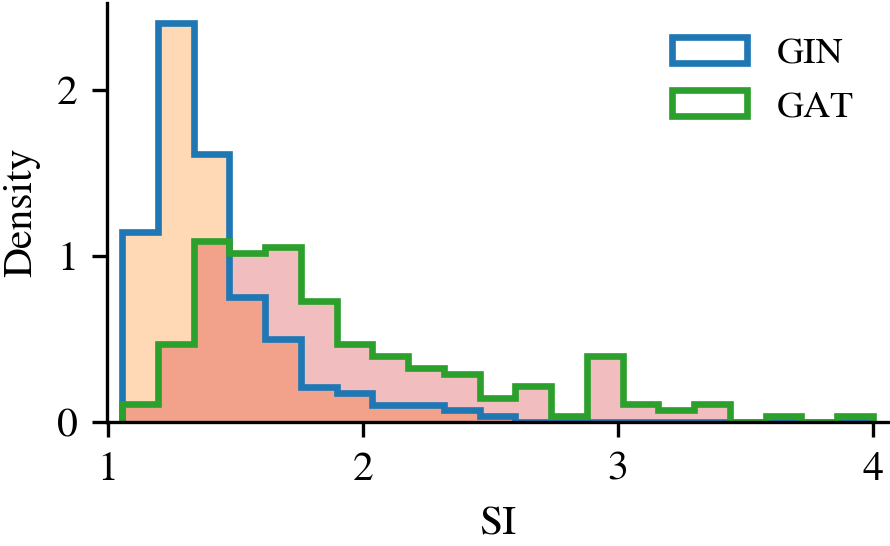

In [43]:

plot_overlaid_histograms(
    datasets={'GIN': results_gin['si_node'], 'GAT': results_gat['si_node']},
    xlabel='SI',
    alpha_fill=0.3
)


/tmp/ipykernel_506231/1570804712.py:71: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


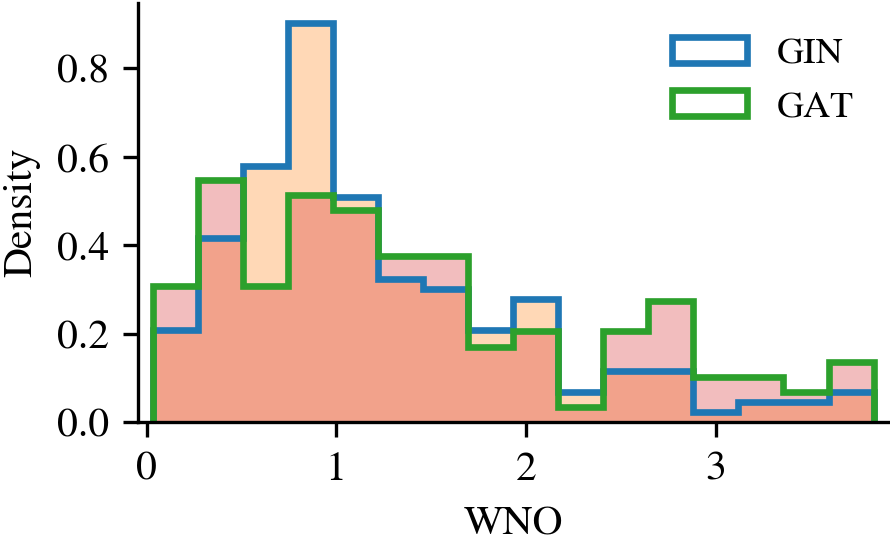

In [33]:
plot_overlaid_histograms(
    datasets={'GIN': results_gin['wno_node'], 'GAT': results_gat['wno_node']},
    xlabel='WNO',
    bins=16,
    alpha_fill=0.3
)


In [58]:
from typing import Dict, Optional, Tuple, Sequence, Union
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes as MplAxes
from matplotlib.transforms import Bbox, ScaledTranslation

# ------------------------------------------------------------
# Shared-label helper: center labels on the union of axes,
# offset by a fixed number of *points* (not figure fraction).
# ------------------------------------------------------------
def place_shared_labels(fig, axes, xlabel=None, ylabel=None,
                        pad_pts: int = 14, fontsize: int = 13, **text_kw):
    """
    Center xlabel/ylabel relative to the union of the given axes (data area),
    and place them pad_pts *points* outside the axes rectangle.

    Accepts `pad=` as an alias for `pad_pts`.
    """
    if "pad" in text_kw:
        pad_pts = text_kw.pop("pad")

    # Normalize axes to a flat list
    if isinstance(axes, MplAxes):
        ax_list = [axes]
    elif isinstance(axes, np.ndarray):
        ax_list = [a for a in axes.ravel().tolist() if isinstance(a, MplAxes)]
    else:
        try:
            ax_list = [a for a in axes if isinstance(a, MplAxes)]
        except TypeError:
            ax_list = [axes]
    if not ax_list:
        raise ValueError("No valid Axes provided to place_shared_labels().")

    fig.canvas.draw()  # finalize layout so positions are correct

    bbox = Bbox.union([ax.get_position() for ax in ax_list])  # figure coordinates
    xc = 0.5 * (bbox.x0 + bbox.x1)
    yc = 0.5 * (bbox.y0 + bbox.y1)

    # Convert points to a figure transform offset
    off_x = ScaledTranslation(0, -(pad_pts/72.0), fig.dpi_scale_trans)   # downward
    off_y = ScaledTranslation(-(pad_pts/72.0), 0,       fig.dpi_scale_trans)   # leftward

    if xlabel:
        fig.text(xc, bbox.y0, xlabel, ha="center", va="top",
                 transform=fig.transFigure + off_x, fontsize=fontsize, **text_kw)
    if ylabel:
        fig.text(bbox.x0, yc, ylabel, ha="right", va="center", rotation="vertical",
                 transform=fig.transFigure + off_y, fontsize=fontsize, **text_kw)


# ------------------------------------------------------------
# Lightweight KDE helpers (no external dependencies)
# ------------------------------------------------------------
def _silverman_bw(x: np.ndarray) -> float:
    """Silverman's rule-of-thumb bandwidth (robustified with IQR)."""
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    n = max(x.size, 1)
    if n < 2:
        return 1.0
    sd  = np.std(x, ddof=1)
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    sigma = sd if iqr <= 0 or not np.isfinite(iqr) else min(sd, iqr/1.34)
    bw = 0.9 * sigma * n ** (-1/5)
    if not np.isfinite(bw) or bw <= 0:
        bw = (sd if np.isfinite(sd) and sd > 0 else 1.0) * n ** (-1/5)
    return bw

def _kde_on_grid(x: np.ndarray, grid: np.ndarray, bw: float,
                 reflect_lower: Optional[float] = None) -> np.ndarray:
    """
    Gaussian KDE evaluated on `grid`, with optional reflection at a lower bound
    (to fix boundary bias). Returns densities whose integral over the real line
    is 1 (pre-truncation).
    """
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return np.zeros_like(grid)

    if reflect_lower is not None:
        L = float(reflect_lower)
        # reflect points within ~3*bw of the boundary
        near = (x - L) < 3.0 * bw
        if np.any(near):
            x = np.concatenate([x, 2*L - x[near]])

    d = (grid[:, None] - x[None, :]) / bw
    dens = np.exp(-0.5 * d**2).sum(axis=1) / (np.sqrt(2*np.pi) * bw * x.size)
    return dens

def _renorm(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """Renormalize y so that the integral over x is 1 (safe for zero area)."""
    A = np.trapz(y, x)
    return y / A if A > 0 else y


# ------------------------------------------------------------
# Main: small-multiples scatter with optional marginal hist/KDE
# ------------------------------------------------------------
def scatter_small_multiples(
    datasets: Dict[str, Dict[str, np.ndarray]],   # {"GIN": results_gin, ...}
    *,
    xkey: str = "wno_node",
    ykey: str = "si_node",
    xlabel: str = "WNO",
    ylabel: str = "SI",
    colors: Optional[Dict[str, str]] = None,      # e.g., {"GAT":"tab:orange"}
    markers: Optional[Dict[str, str]] = None,     # e.g., {"GIN":"o","GAT":"^"}
    size: float = 14,
    linewidth: float = 0.7,
    open_markers: bool = True,
    alpha: float = 1.0,
    rasterized: bool = False,

    # shared limits/ticks
    xlim: Optional[Tuple[float, float]] = None,
    ylim: Optional[Tuple[float, float]] = (0.8, 3.0),
    xticks: Optional[Sequence[float]] = None,
    yticks: Optional[Sequence[float]] = (1, 2, 3),

    # references & panel annotation
    vline: Optional[float] = 0.0,
    hline: Optional[float] = 1.0,
    annotate: bool = True,                         # model name inside each panel

    # marginals
    add_marginals: bool = False,
    marginal_frac: float = 0.22,                   # strip height/width relative to main
    marginal_style: str = "kde",                   # "hist", "kde", or "both"
    bins: Union[int, str] = "fd",                  # for hist
    marginal_alpha: float = 0.18,
    marginal_linewidth: float = 1.0,
    marginal_norm: str = "density",                # "density" | "probability" | "count"

    # KDE controls (shared across panels)
    kde_points: int = 256,
    kde_bw_x: Optional[float] = None,
    kde_bw_y: Optional[float] = None,
    kde_lower_x: Optional[float] = None,          # hard lower support (e.g., 0.0 for WNO)
    kde_lower_y: Optional[float] = None,          # hard lower support (e.g., 1.0 for SI)
    kde_reflect_lower_x: Optional[float] = None,  # default to kde_lower_x if provided
    kde_reflect_lower_y: Optional[float] = None,  # default to kde_lower_y if provided
    kde_normalize: bool = True,                    # renormalize truncated KDE to area 1
):
    """
    Draw one row of scatter plots (one per model), with optional top/right
    marginals (histograms and/or Gaussian KDEs). All panels share axis limits,
    tick locations, histogram bins, and KDE bandwidths for fair comparison.

    Returns
    -------
    fig : matplotlib.figure.Figure
    axes : list[Axes]  (main scatter axes only)
    """
    if not datasets:
        raise ValueError("Provide at least one dataset.")

    labels = list(datasets.keys())
    k = len(labels)

    # Figure with one column per model; each column hosts a 2x2 sub-gridspec
    fig = plt.figure(figsize=(3.25*k, 2), dpi=300, constrained_layout=True)
    outer = fig.add_gridspec(1, k)

    # ---- Compute shared limits if not provided ----
    if xlim is None or ylim is None:
        allx, ally = [], []
        for d in datasets.values():
            x = np.asarray(d[xkey], float)
            y = np.asarray(d[ykey], float)
            m = np.isfinite(x) & np.isfinite(y)
            allx.append(x[m]); ally.append(y[m])
        X = np.concatenate(allx) if allx else np.array([])
        Y = np.concatenate(ally) if ally else np.array([])

        if xlim is None and X.size > 0:
            pad = 0.03 * (X.max() - X.min() or 1.0)
            xlim = (X.min() - pad, X.max() + pad)
        if ylim is None and Y.size > 0:
            pad = 0.03 * (Y.max() - Y.min() or 1.0)
            ylim = (Y.min() - pad, Y.max() + pad)

    # ---- Shared histogram bins (if needed) ----
    if add_marginals and ("hist" in marginal_style or "both" in marginal_style):
        Xall = np.concatenate([np.asarray(datasets[l][xkey], float) for l in labels])
        Yall = np.concatenate([np.asarray(datasets[l][ykey], float) for l in labels])
        edges_x = np.histogram_bin_edges(Xall[np.isfinite(Xall)], bins=bins)
        edges_y = np.histogram_bin_edges(Yall[np.isfinite(Yall)], bins=bins)

    # ---- Shared KDE grids & bandwidths (if needed) ----
    if add_marginals and ("kde" in marginal_style or "both" in marginal_style):
        Xall = np.concatenate([np.asarray(datasets[l][xkey], float) for l in labels])
        Yall = np.concatenate([np.asarray(datasets[l][ykey], float) for l in labels])
        if kde_bw_x is None: kde_bw_x = _silverman_bw(Xall)
        if kde_bw_y is None: kde_bw_y = _silverman_bw(Yall)

        # Respect hard lower supports (cut the evaluation grid at those bounds)
        gx_lo = max(xlim[0], kde_lower_x) if (kde_lower_x is not None and xlim is not None) else (xlim[0] if xlim else np.nan)
        gy_lo = max(ylim[0], kde_lower_y) if (kde_lower_y is not None and ylim is not None) else (ylim[0] if ylim else np.nan)
        gx = np.linspace(gx_lo, xlim[1], kde_points) if xlim else None
        gy = np.linspace(gy_lo, ylim[1], kde_points) if ylim else None

        # Default reflection at given lower bounds
        if kde_lower_x is not None and kde_reflect_lower_x is None:
            kde_reflect_lower_x = kde_lower_x
        if kde_lower_y is not None and kde_reflect_lower_y is None:
            kde_reflect_lower_y = kde_lower_y

    # ---- Draw panels ----
    main_axes = []
    # Set up a fixed color per label (consistent across panels even with new Axes)
    default_cycle = plt.rcParams.get("axes.prop_cycle", None)
    default_colors = (default_cycle.by_key()["color"]
                      if default_cycle and "color" in default_cycle.by_key()
                      else ["C0","C1","C2","C3","C4","C5","C6","C7","C8","C9"])

    for idx, label in enumerate(labels):
        # 2x2 subgrid per panel:
        # [ top hist/KDE | empty ]
        # [ main scatter  | right hist/KDE ]
        inner = outer[0, idx].subgridspec(
            2, 2,
            height_ratios=[marginal_frac if add_marginals else 0.001, 1.0],
            width_ratios=[1.0, marginal_frac if add_marginals else 0.001],
            hspace=0.0, wspace=0.0
        )
        ax_top   = fig.add_subplot(inner[0, 0]) if add_marginals else None
        ax_main  = fig.add_subplot(inner[1, 0])
        ax_right = fig.add_subplot(inner[1, 1]) if add_marginals else None
        main_axes.append(ax_main)

        # Data
        d = datasets[label]
        x = np.asarray(d[xkey], float)
        y = np.asarray(d[ykey], float)
        m = np.isfinite(x) & np.isfinite(y)
        x, y = x[m], y[m]

        # Style per panel
        color  = (colors or {}).get(label, default_colors[idx % len(default_colors)])
        marker = (markers or {}).get(label, "o")
        sc_kw = dict(s=size, marker=marker, alpha=alpha,
                     linewidths=linewidth, zorder=2, rasterized=rasterized)

        # Scatter
        if open_markers:
            ax_main.scatter(x, y, facecolors='none', edgecolors=color, **sc_kw)
        else:
            ax_main.scatter(x, y, color=color, **sc_kw)

        # Reference lines
        if vline is not None: ax_main.axvline(vline, color='0.5', linestyle='--', linewidth=1, zorder=1)
        if hline is not None: ax_main.axhline(hline, color='0.5', linestyle='--', linewidth=1, zorder=1)

        # Panel label
        if annotate:
            ax_main.text(0.98, 0.95, label, transform=ax_main.transAxes,
                         ha='right', va='top', fontsize=10)

        # Aesthetics + shared axes
        ax_main.spines['top'].set_visible(False)
        ax_main.spines['right'].set_visible(False)
        if xlim is not None: ax_main.set_xlim(*xlim)
        if ylim is not None: ax_main.set_ylim(*ylim)
        if xticks is not None: ax_main.set_xticks(xticks)
        if yticks is not None: ax_main.set_yticks(yticks)

        # ---- Marginals ----
        if add_marginals:
            # HISTOGRAMS
            if "hist" in marginal_style or "both" in marginal_style:
                if marginal_norm == "probability":
                    w_x = np.ones_like(x) / max(len(x), 1); w_y = np.ones_like(y) / max(len(y), 1)
                    density = False
                elif marginal_norm == "density":
                    w_x = w_y = None; density = True
                else:
                    w_x = w_y = None; density = False

                ax_top.hist(x, bins=edges_x, weights=w_x, density=density,
                            histtype="stepfilled", alpha=marginal_alpha,
                            color=color, linewidth=marginal_linewidth)
                ax_top.hist(x, bins=edges_x, weights=w_x, density=density,
                            histtype="step", color=color, linewidth=marginal_linewidth)

                ax_right.hist(y, bins=edges_y, weights=w_y, density=density,
                              orientation="horizontal", histtype="stepfilled",
                              alpha=marginal_alpha, color=color, linewidth=marginal_linewidth)
                ax_right.hist(y, bins=edges_y, weights=w_y, density=density,
                              orientation="horizontal", histtype="step",
                              color=color, linewidth=marginal_linewidth)

            # KDEs (with hard cutoffs + optional reflection)
            if "kde" in marginal_style or "both" in marginal_style:
                fx = _kde_on_grid(x, gx, bw=kde_bw_x, reflect_lower=kde_reflect_lower_x)
                fy = _kde_on_grid(y, gy, bw=kde_bw_y, reflect_lower=kde_reflect_lower_y)
                if kde_normalize:
                    fx = _renorm(gx, fx)
                    fy = _renorm(gy, fy)

                # top (x), drawn only on valid support grid gx
                ax_top.plot(gx, fx, color=color, linewidth=marginal_linewidth)
                ax_top.fill_between(gx, 0, fx, color=color, alpha=marginal_alpha, linewidth=0)

                # right (y), horizontal
                ax_right.plot(fy, gy, color=color, linewidth=marginal_linewidth)
                ax_right.fill_betweenx(gy, 0, fy, color=color, alpha=marginal_alpha, linewidth=0)

            # Hide axes/ticks on marginals, but keep the main axes limits
            if xlim is not None: ax_top.set_xlim(*xlim)
            if ylim is not None: ax_right.set_ylim(*ylim)
            ax_top.axis("off"); ax_right.axis("off")

    # Shared labels relative to the *main* axes only (ignores marginals)
    place_shared_labels(fig, main_axes, xlabel=xlabel, ylabel=ylabel, pad=18, fontsize=13)

    return fig, main_axes


/tmp/ipykernel_756701/55371245.py:250: UserWarning: You passed a edgecolor/edgecolors ('tab:green') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_main.scatter(x, y, facecolors='none', edgecolors=color, **sc_kw)
/tmp/ipykernel_756701/55371245.py:96: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  A = np.trapz(y, x)


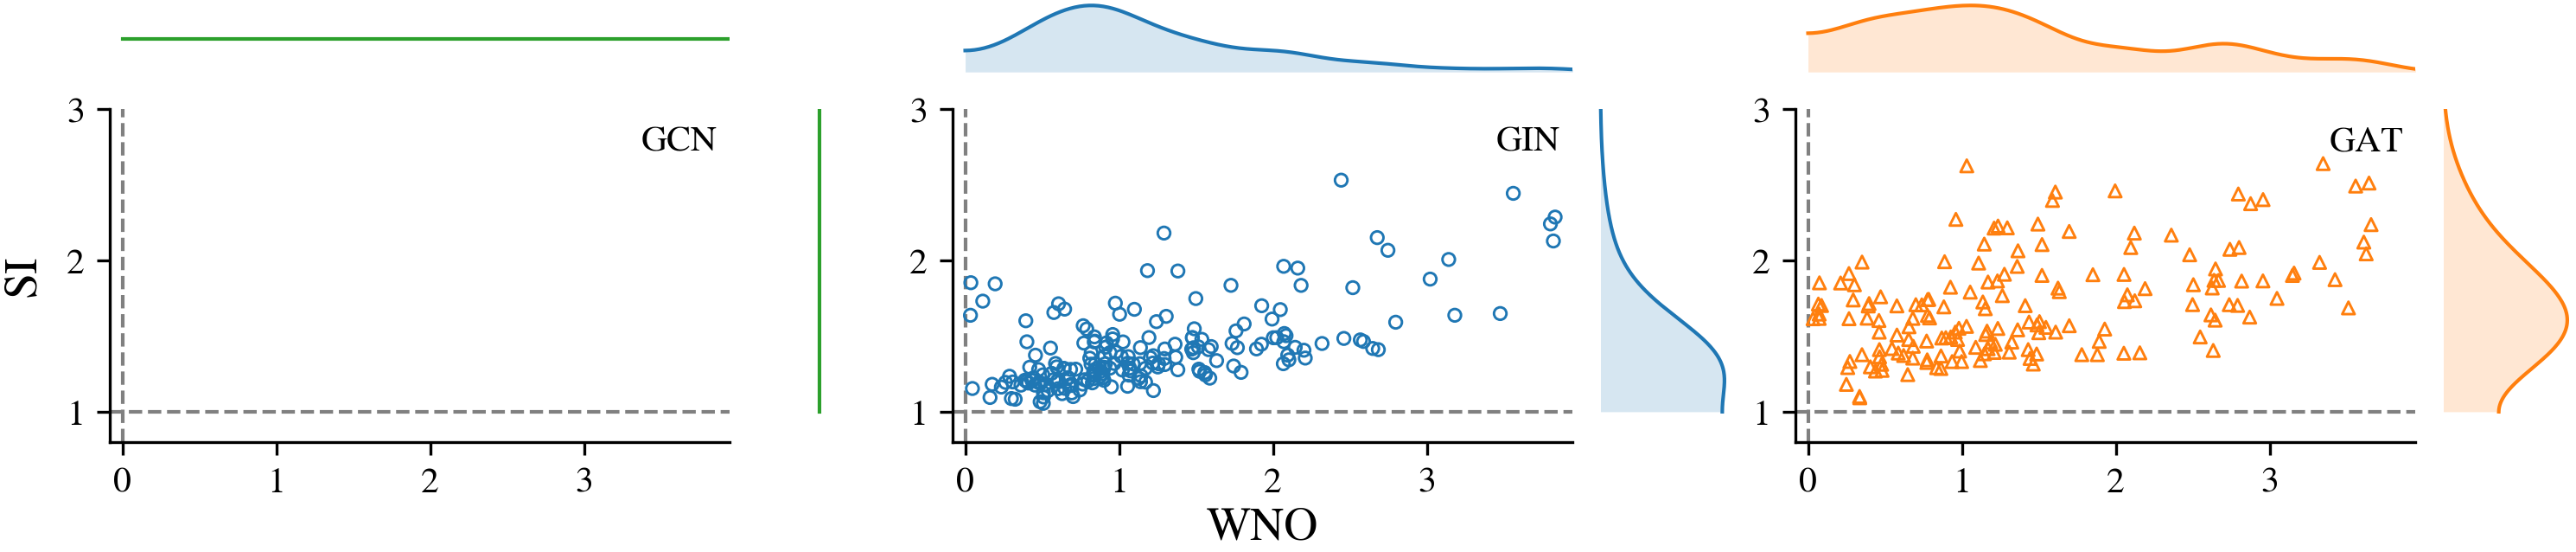

In [52]:
PALETTE = {"GCN": "tab:green", "GIN": "tab:blue", "GAT": "tab:orange"}

fig, axes = scatter_small_multiples(
    {"GCN": results_gcn, "GIN": results_gin, "GAT": results_gat},
    xkey="wno_node", ykey="si_node",
    xlabel="WNO", ylabel="SI",
    colors=PALETTE, markers={"GCN":"x", "GIN":"o", "GAT":"^"},
    size=12, linewidth=0.7, open_markers=True,
    xticks=[0,1,2,3], yticks=[1,2,3], #ylim=(0.8, 3.0),
    add_marginals=True, marginal_style="kde",
    kde_lower_x=0.0, kde_lower_y=1.0,   # hard cutoffs
    kde_normalize=True
)
plt.savefig("figures/scatter_row_kde_marginals_node.pdf", bbox_inches="tight", pad_inches=0.02)


In [ ]:
from src.data import SharedDataset
from torch_geometric.loader import DataLoader

dl = DataLoader(SharedDataset.CONJUNCTION.train_data)

def fast_hash(data_loader):
    num_graphs = len(dl)
    total_nodes = sum([g.x.shape[0] for g in dl])
    return hash(num_graphs * total_nodes)

fast_hash(dl)


In [ ]:
DataLoader(SharedDataset.MOTIFS.train_data).__hash__()

In [ ]:
DataLoader(SharedDataset.MOTIFS.train_data, shuffle=True)


In [ ]:
len(SharedDataset.MOTIFS.train_data)